## Graphical User Interface

The graphical user interface is a visual interface that allows the user to interact with the electronic device. GUI is realise through a combination of software and hardware working together. The graphics system consists of an application, a graphics toolkit and the graphics hardware. Below is a typical block diagram of a graphics system connected to a CPU.
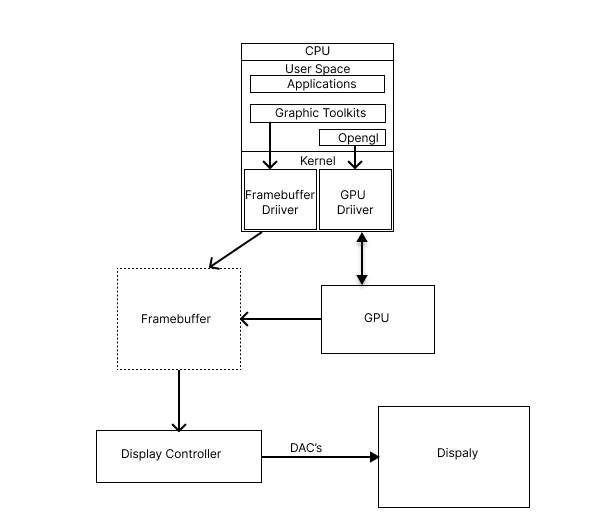

At the lowest level is the display, which is driven by the display controller. The display controller takes the content to be displayed from the framebuffer and sends them as electrical signals to the display using DAC's. The framebuffer itself is filled up by CPU or the GPU depending on the system. The software architecture of GUI on the CPU consists of the layers - application, graphics toolkit, opengl and the drivers.

## Displays and Framebuffers

Framebuffer is a memory pixel buffer that can be located on the CPU or the graphics card address space. The content that has to presented on the dispaly should be continouly updated into this buffer. Typically a system contains two framebuffers, a visible and a non-visible buffer. The non-visible buffer is updated while the other buffer is visible, on completion the two buffer addresses are exchanged to update the display. Display controller refreshes the display by continously reading the frame buffer. Framebuffer has the RGB values corresponding to each pixel on the display. Display controller takes these
bytes and converts them to electrical signals using DAC's and sends these electrical signals to the display.

## Framebuffer Driver and Graphics Driver
Typically the framebuffer driver directly updates the display controller's framebuffer. This means the CPU is doing all the graphics rendering operations. 
When it comes to highly parallel tasks like graphics rendering the GPU's are much faster than the CPU's. To use a graphics device like GPU for graphics rendering operations, the graphics driver needs to be used. Here the GPU is resposible for updating the display controller's framebuffer. Using the graphics driver also means that the CPU is free to do other tasks as the GPU is doing the rendering. 
The graphics driver is reponsible to keep track of the GPU's state, process data to be sent to the GPU and compile the code to be run by the GPU amoung other things.

## Graphics toolkits and OpenGL
The various graphic toolkits available provide the windowing functionality that is required to create graphical user interface applications. In cases where harware acceleration is not used, typically the graphic
toolkits directly use the framebuffer driver to update the display. When we want to use the GPU(hardware acceleration), the graphics toolkit should use OpenGL. OpenGL is an application programming interface standard
for rendering 2D and 3D vector graphics. Depending on the GPU being used that vendor specific OpenGL library(implementation) should be used by the graphics toolkit. The OpenGL library interacts with the
Graphics Driver to update the display.

## Getting Started with OpenGL
* OpenGL is a large state machine, a collection of variables that define how OpenGL should currently operate.When using OpenGL, we often change its state by setting some options, manipulating some buffers and then render using the current context. OpenGL has state-changing and state-using functions.
* An object in OpenGL is a collection of options that represents a subset of OpenGL's state. Object can be visualized as a C struct. OpenGL context can be visualized as one large struct containing all the objects.
* OpenGL does its rendering using a graphics pipeline, each step of the pipeline is highly parallel in nature and is done by a program being executed on the GPU. These programs are called shaders.
* The input to the graphics pipeline is a vertex data, which contains data about the 3D vertices(points). What OpenGL should do with these cordinates should be given to it as a hint in the drawing commands. Do we want these points to be redered as a collection of points or a collection of triangles or as a straight line.
* At a minimum OpenGL should be given the vertex shader(first step in the graphics pipeline) and the fragment shader(last but one step in the graphics pipeline). Vertex shader allows us to do some basic processing on the vertex attributes. Fragment shader applies the 3D effects and calculates the final color of each pixel.
* First vertex data is constructed. To give it as input to the graphics pipeline memory should be allocated on the GPU, then vertex data should be copied to this memory.  For example if we want to draw a single 2D triangle
```C++
//vertex data - 3 vertices of the triangle in normalized device cordinates
float vertices[] = {
    -0.5f, -0.5f, 0.0f,
     0.5f, -0.5f, 0.0f,
     0.0f,  0.5f, 0.0f
};
```
```C++
//create memory to copy vertex data, this memory is managed by vertex buffer objects(vbo) internally
unsigned int vbo;
glGenBuffers(1, &vbo);
//bind the created buffer to the vertex data. OpenGL has many buffers, GL_ARRAY_BUFFER indicates vertex data buffer data
//at a given time, one buffer of a given buffer type can be bond to the OpenGL state machine
glBindBuffer(GL_ARRAY_BUFFER, vbo);
//copy the vertex data to the buffer memory, glBufferData is the method used to copy any buffer data
glBufferData(GL_ARRAY_BUFFER, sizeof(vertices), vertices, GL_STATIC_DRAW);
```
* Write a vertex shader and compile. Shaders are programmed in GLSL(graphics library shader language). Shader code needs to stored in a const string and given to OpenGL at run time for compilation.
```C++
//vertex shader source code
//fisrt line specifies GLSL version and to use the OpenGL core mode
//next we declare all the input vertex attributes in the vertex shader with the in keyword. Right now we only have position data so we only need a single vertex attribute, vec3 is one 3D cordinate
//the out put of the vertex shader is what we set to gl_Position, which should be a 4D vector
//in the simple implementation we are just forwarding the cordinates
const char *vertexShaderSource = "#version 330 core\n"
    "layout (location = 0) in vec3 aPos;\n"
    "void main()\n"
    "{\n"
    "   gl_Position = vec4(aPos.x, aPos.y, aPos.z, 1.0);\n"
    "}\0";
//create the vertex shader, GL_VERTEX_SHADER specifies the type of the shader
unsigned int vertexShader;
vertexShader = glCreateShader(GL_VERTEX_SHADER);
//attach the shader source code compile
glShaderSource(vertexShader, 1, &vertexShaderSource, NULL);
glCompileShader(vertexShader);
```
* Write a fragment shader and compile.
```C++
//fragment shader only requires one output variable vec4(RGBA) that defines the final color of each pixel.
//out keyword is used to declare output values
//Orange is set to FragColor with RGB values
const char *fragmentShaderSource = "#version 330 core\n"
    "out vec4 FragColor;\n"
    "void main()\n"
    "{\n"
    "FragColor = vec4(1.0f, 0.5f, 0.2f, 1.0f);\n"
    "} \0";
//create the vertex shader, GL_FRAGMENT_SHADER specifies the type of the shader
unsigned int fragmentShader;
fragmentShader = glCreateShader(GL_FRAGMENT_SHADER);
//attach the shader source code compile
glShaderSource(fragmentShader, 1, &fragmentShaderSource, NULL);
glCompileShader(fragmentShader);
```
* A shader program is the linked version of all the shaders combined. The two shader programs we compiled should be linked to the complete shader program. Then the shared program should be activated to be used by the render calls.
```C++
//create a shader program
unsigned int shaderProgram;
shaderProgram = glCreateProgram();
//attach and link vertex and fragment shader to the shader program
glAttachShader(shaderProgram, vertexShader);
glAttachShader(shaderProgram, fragmentShader);
glLinkProgram(shaderProgram);
//activate the shader program
glUseProgram(shaderProgram);
//delete vertex and fragment shaders, no longer required
glDeleteShader(vertexShader);
glDeleteShader(fragmentShader); 
```
* The vertex shader allows us to specify any input we want in the form of vertex attributes, so we have specify what part of our input vertex data goes to which vertex attribute in the vertex shader. This means we have to specify how OpenGL should interpret the vertex data before rendering.
```C++
//use glVertexAttribPointer to tell OpenGL on how it should interrupt the input vertex data
//for our vertex data, its 3 floating point 3D cordinates in a packed array
//param1 - specifies the vertex attribute we want to configure, we have to specify this location in the vertex shader
//param2 - size of 1 vertex attribute, param3 - specifies the type of data, param4 - specifies if data has to be normalized
//param5 - stride, space between continous vertex attributes, param6 - offset, of where the position data starts in the buffer
glVertexAttribPointer(0, 3, GL_FLOAT, GL_FALSE, 3 * sizeof(float), (void*)0);
//enable the vertex attribute of the given location
glEnableVertexAttribArray(0);  
```
* This process has to be repeated every time we want to draw a object. Since typically there are 100's of objects with many attributes, OpenGL allows us to save all these configurations between vertex data and vertex attributes into a single object called vertex array object(VAO).A VAO can be bound just like a vertex buffer object and any subsequent vertex attribute calls from that point on will be stored inside the VAO.This makes switching between different objects drawing as easy as binding a different VAO.
```C++
//create a virtual array object
unsigned int VAO;
glGenVertexArrays(1, &VAO);
//to use a VAO you have to do is bind the VAO using
glBindVertexArray(VAO);
//from this point on we should bind/configure the corresponding VBO(s) and attribute pointer(s) and then unbind the VAO for later use
```
* Usually when you have multiple objects you want to draw, you first generate/configure all the VAOs (and thus the required VBO and attribute pointers) and store those for later use. The moment we want to draw one of our objects, we take the corresponding VAO, bind it, then draw the object and unbind the VAO again.
* Finally to draw OpenGL has glDrawArrays to draw primitives using the given shader, vertex attributes and data
```C++
//takes the primitve we want to draw, vertex array starting index, number of vertices
glDrawArrays(GL_TRIANGLES, 0, 3);
```

## Framebuffer Driver and its usage
* The framebuffer driver itself should be implemented as a PCI device driver, registered into the PCI subsystem. In the driver we have to mention the vendor ID and device ID of the PCI hardware to which the display controllers framebuffer memory is connected. The driver should obtain the memory mapped start address and size of the framebuffer(PCI device). Then this physical address should be remmaped to the virtual memory page tables using ioremap method, to read/write from/into the framebuffer.
* From the point of view of the user space, if the display device needs to be accessed for reading or writing, then only the framebuffer device such as /dev/fb0 has to be accessed.To open the framebuffer device.
```C++
#include <linix/fb.h>
// 
int fbfd = open("/dev/fb0", O_RDWR);
```
* Get the dimenions of the screen
```C++
struct fb_var_screeninfo vinfo;
ioctl (fbfd, FBIOGET_VSCREENINFO, &vinfo);
int fb_width = vinfo.xres;
int fb_height = vinfo.yres;
int fb_bpp = vinfo.bits_per_pixel;
int fb_bytespp = fb_bpp / 8;
```
* Map the screen into the memory. It's not strictly necessary to map the screen into memory, you can just make ordinary write() calls on the framebuffer's filehandle. Mapping into the memory makes it more flexible.
```C++
int fb_data_size = fb_width * fb_height * fb_bytespp;
char *fbdata = mmap (0, fb_data_size, PROT_READ | PROT_WRITE, MAP_SHARED, fbfd, (off_t)0);
```
* Write to the mapped screen
```C++
//blank the entire screen
memset (fbdata, 0, fb_data_size);
//write to a specific pixel, order should be bgra
int offset = (y * fb_width + x) * 4;
fbdata [offset + 0] = b;
fbdata [offset + 1] = g;
fbdata [offset + 2] = r;
fbdata [offset + 3] = 0;
```
* Close the framebuffer
```C++
munmap (fbdata, fb_data_size);
close (fbfd);
```